In [129]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [130]:
cd '/content/drive/MyDrive/Colab Notebooks/'

/content/drive/MyDrive/Colab Notebooks


In [131]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.utils import to_categorical
import numpy as np
!pip install missingno
!pip install plotly.express
import missingno as msno
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from keras.utils import plot_model
from IPython.display import Image
from sklearn.metrics import classification_report, accuracy_score

from keras_tuner.engine.hyperparameters import HyperParameters
from keras_tuner import RandomSearch, Hyperband, BayesianOptimization
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import LearningRateScheduler, TensorBoard
import keras_tuner as kt
from sklearn.metrics import classification_report, confusion_matrix


In [132]:
# Define the paths for train and test datasets in your Google Drive
train_path = '/content/drive/MyDrive/Colab Notebooks/train.csv'
test_path = '/content/drive/MyDrive/Colab Notebooks/test.csv'

# Load the datasets
import pandas as pd
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

In [133]:
# Check for missing values in train and test data
print(train_df.isnull().sum())


ID                   0
Gender               0
Ever_Married       140
Age                  0
Graduated           78
Profession         124
Work_Experience    829
Spending_Score       0
Family_Size        335
Var_1               76
Segmentation         0
dtype: int64


In [134]:
print(test_df.isnull().sum())

ID                   0
Gender               0
Ever_Married        50
Age                  0
Graduated           24
Profession          38
Work_Experience    269
Spending_Score       0
Family_Size        113
Var_1               32
dtype: int64


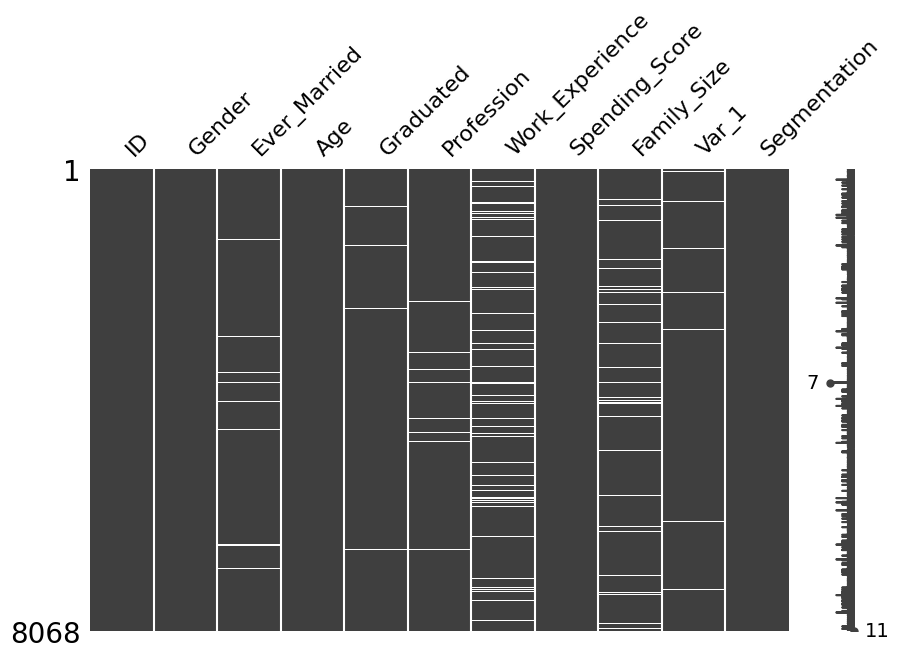

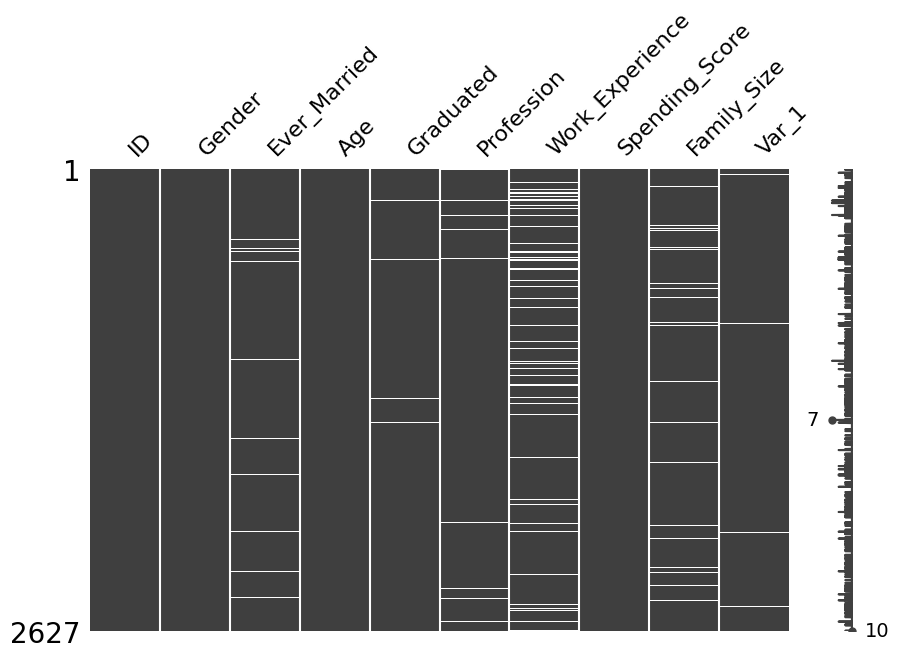

In [138]:
!pip install missingno
!pip install plotly.express
import missingno as msno
import matplotlib.pyplot as plt
import plotly.express as px
# Visualize missing values
msno.matrix(train_df, figsize=(10, 6)) #removed extra indentation
plt.show() #removed extra indentation
msno.matrix(test_df, figsize=(10, 6)) #removed extra indentation
plt.show() #removed extra indentation

# Plot distributions of numerical columns
for column in train_df.select_dtypes(include=['float64', 'int64']).columns:
    fig = px.histogram(train_df, x=column, title=f'Distribution of {column} in Train data')
    fig.show()
for column in test_df.select_dtypes(include=['float64', 'int64']).columns:
    fig = px.histogram(test_df, x=column, title=f'Distribution of {column} in Test data')
    fig.show()

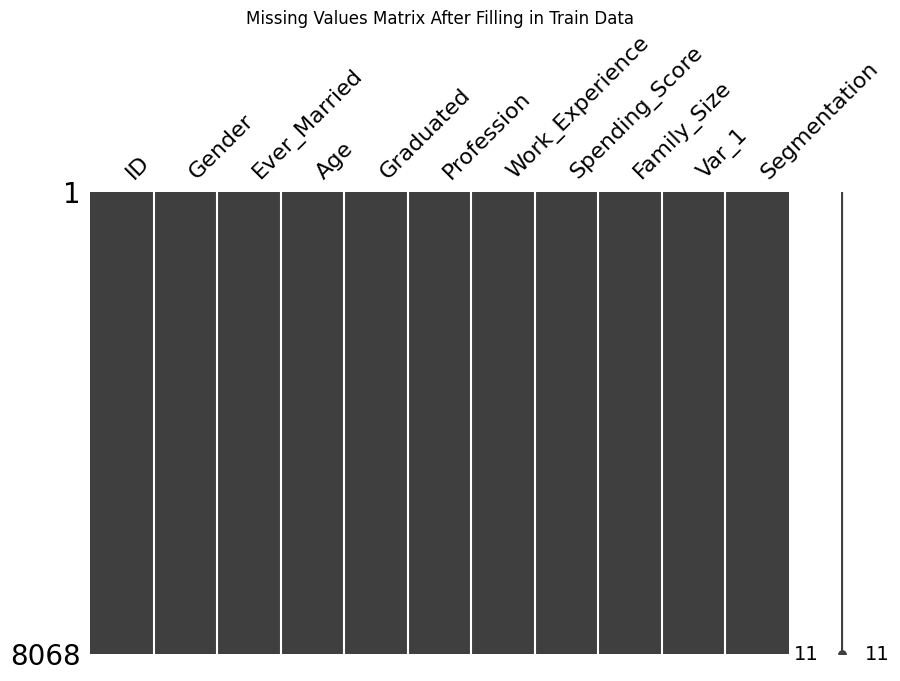

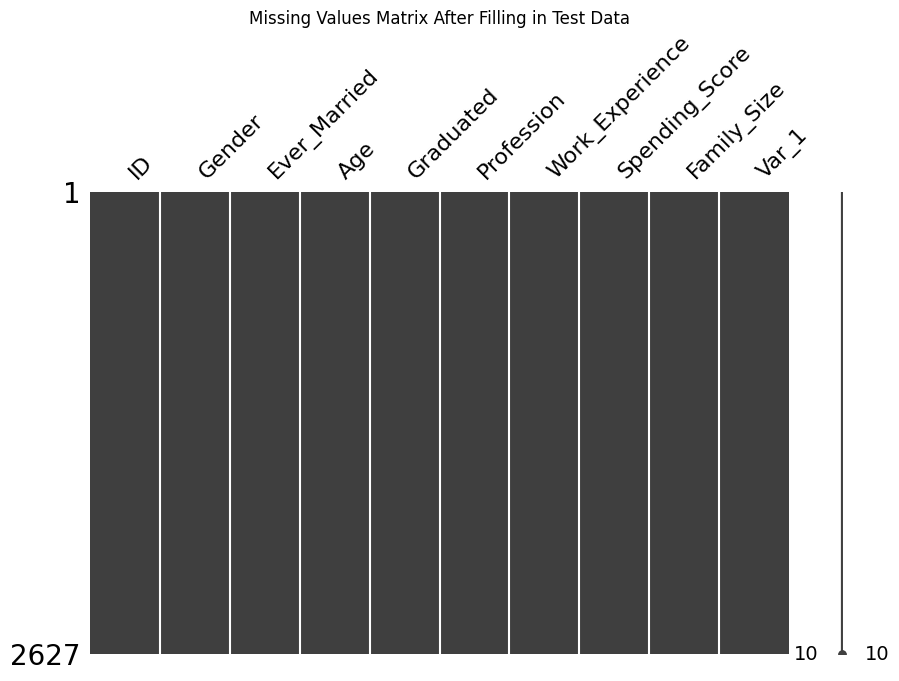

In [109]:
# Copy the original datasets to new variables
train_df_copy = train_df.copy()
test_df_copy = test_df.copy()

# Handle missing values for categorical variables (mode)
for df in [train_df_copy, test_df_copy]:
    categorical_columns = df.select_dtypes(include=['object']).columns
    for column in categorical_columns:
        df[column].fillna(df[column].mode()[0], inplace=True)

# Handle missing values for numerical variables (median)
for df in [train_df_copy, test_df_copy]:
    numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns
    for column in numerical_columns:
        df[column].fillna(df[column].median(), inplace=True)

# Visualize missing values for both train and test datasets
# Train dataset visualization
msno.matrix(train_df_copy, figsize=(10, 6))
plt.title('Missing Values Matrix After Filling in Train Data')
plt.show()

# Test dataset visualization
msno.matrix(test_df_copy, figsize=(10, 6))
plt.title('Missing Values Matrix After Filling in Test Data')
plt.show()


Perform encoding on categorical variables and scaling on numerical features and Prepare the Data

For train.csv:

▪ Split the data into X_train (features) and y_train (target labels).

For test.csv:

▪ Prepare the features (X_test), ensuring that all preprocessing steps (scaling, encoding) applied to train.csv are replicated on test.csv.

In [110]:
categorical_columns = X_train.select_dtypes(include=['object']).columns  # Categorical columns
numerical_columns = X_train.select_dtypes(include=['float64', 'int64']).columns  # Numerical columns

#Create a preprocessor that applies OneHotEncoder to categorical columns and StandardScaler to numerical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),  # Impute missing numerical data with median
            ('scaler', StandardScaler())  # Scale numerical data
        ]), numerical_columns),

        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),  # Impute missing categorical data with most frequent
            ('encoder', OneHotEncoder(drop='first'))  # OneHotEncode categorical data
        ]), categorical_columns)
    ])

#Apply the preprocessor to X_train and fit the transformer
X_train_prepared = preprocessor.fit_transform(X_train)

#Apply the same preprocessor to the test data (X_test)
X_test_prepared = preprocessor.transform(test_data)  # Only transform, do not fit on test data

#Check the shapes of the prepared data
print(f'Shape of X_train_prepared: {X_train_prepared.shape}')
print(f'Shape of X_test_prepared: {X_test_prepared.shape}')


Shape of X_train_prepared: (8068, 23)
Shape of X_test_prepared: (2627, 23)


In [111]:
# One-hot encode the target labels
y_train_transformed = pd.get_dummies(y_train).values

# Display the shape of the encoded labels
print("Shape of y_train_transformed:", y_train_transformed.shape)

Shape of y_train_transformed: (8068, 4)


Model 1 - Best Practices Model

Build a neural network model with at least two hidden layers using the ReLU activation function.

Use softmax as the activation function for the output layer to handle multi-class classification.

Use categorical cross-entropy as the loss function and Adam optimizer.

In [112]:
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_prepared.shape[1],)),  # First hidden layer
    Dense(32, activation='relu'),  # Second hidden layer
    Dense(y_train_transformed.shape[1], activation='softmax')  # Output layer
])

# Step 4: Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model Training:

Train the model using the train.csv data (X_train, y_train) for 50 epochs with a batch size of 32.

Use early stopping to prevent overfitting (monitor the validation loss and set a patience of 5 epochs).

Use 20% of the training data as a validation set during training

In [113]:
# Import necessary libraries
from tensorflow.keras.callbacks import EarlyStopping

# Step 1: Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Step 2: Train the model with early stopping
history = model.fit(
    X_train_prepared,
    y_train_transformed,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)



Epoch 1/50
202/202 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.3914 - loss: 1.2837 - val_accuracy: 0.5031 - val_loss: 1.1336
Epoch 2/50
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5061 - loss: 1.1118 - val_accuracy: 0.4957 - val_loss: 1.0961
Epoch 3/50
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5248 - loss: 1.0896 - val_accuracy: 0.5161 - val_loss: 1.0869
Epoch 4/50
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5352 - loss: 1.0566 - val_accuracy: 0.5130 - val_loss: 1.0804
Epoch 5/50
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5251 - loss: 1.0611 - val_accuracy: 0.5130 - val_loss: 1.0786
Epoch 6/50
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5432 - loss: 1.0429 - val_accuracy: 0.5124 - val_loss: 1.0747
Epoch 7/50
202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5439 - loss: 1.0387 - val_accuracy: 0.5124 - val_loss: 1.0698
Epoch 8/50
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5515 - loss: 1.0198 - val_accuracy: 0.

Model Summary:

Print the model architecture summary to review the structure.

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │           1,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │             132 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,246 (43.93 KB)

 Trainable params: 3,748 (14.64 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 7,498 (29.29 KB)

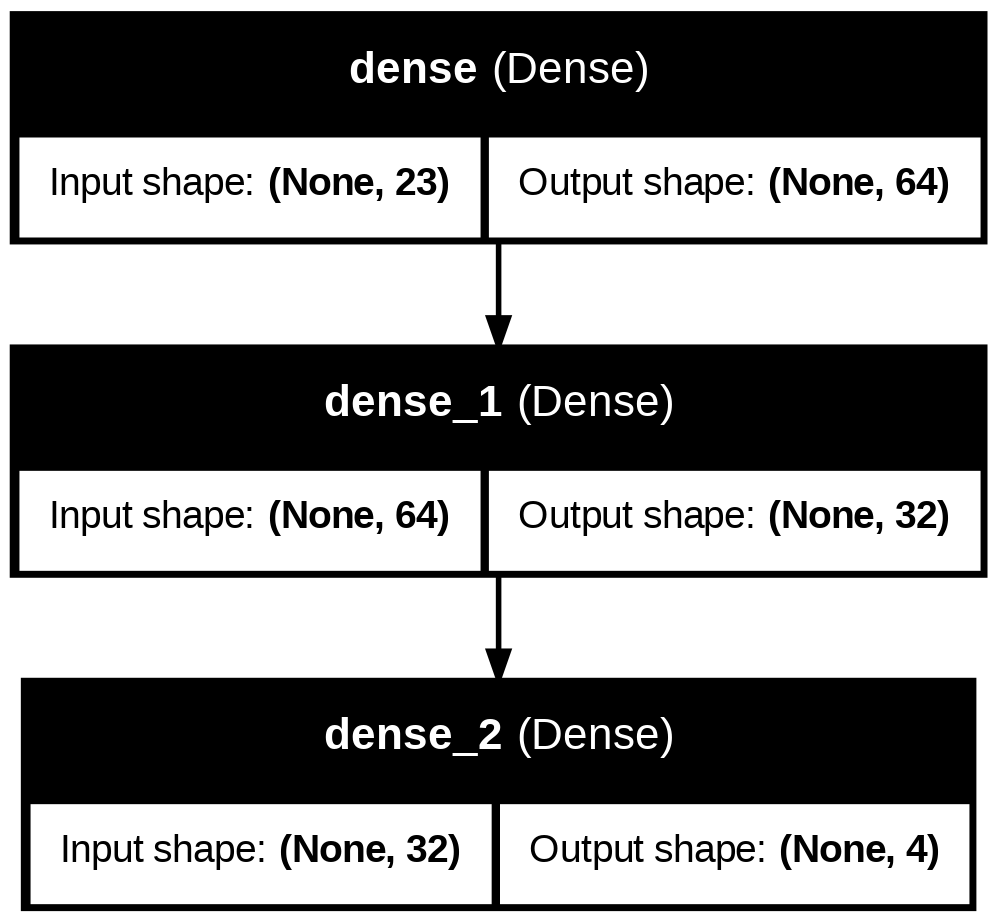

In [114]:
# Print the model architecture summary
model.summary()
# Show the model structure
plot_model(model, to_file='model_1_structure.png', show_shapes=True, show_layer_names=True)
from IPython.display import Image
Image(filename='model_1_structure.png')

Model 2 - Hyperparameter Optimization Using Keras Tuner

Implement Keras Tuner:

Use Keras Tuner to optimize the following hyperparameters:

▪ Number of hidden layers.

▪ Number of neurons in each layer.

▪ Learning rate.

▪ Activation functions.

Set up a search space that explores different combinations of these hyperparameters. Experiment =5

In [117]:
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

def build_model(hp):
    model_2 = Sequential()

    # Define the input layer based on the shape of X_train
    input_shape = X_train_transformed.shape[1]

    # Tune the number of hidden layers from 1 to 10
    for i in range(hp.Int('num_layers', 1, 10)):

        model_2.add(Dense(units=hp.Int(f'units_{i}', min_value=32, max_value=256, step=32),
                        activation='relu'))

    model_2.add(Dense(4, activation='softmax'))

    learning_rate = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])

    # Compile the model
    model_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model_2

Reloading Tuner from my_dir/helloworld/tuner0.json
Epoch 1/50
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5729 - loss: 0.9884 - val_accuracy: 0.5198 - val_loss: 1.0703
Epoch 2/50
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5642 - loss: 0.9872 - val_accuracy: 0.5130 - val_loss: 1.0665
Epoch 3/50
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5779 - loss: 0.9870 - val_accuracy: 0.5254 - val_loss: 1.0783
Epoch 4/50
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5697 - loss: 0.9930 - val_accuracy: 0.5180 - val_loss: 1.0696
Epoch 5/50
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5688 - loss: 0.9813 - val_accuracy: 0.5161 - val_loss: 1.0670


In [118]:
tuner.search(X_train_transformed, y_train_encoded, epochs=20, validation_split=0.2, callbacks=[early_stopping])
# Step 4: Train the best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)
best_model.fit(X_train_transformed, y_train_encoded, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])


Epoch 1/50
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5713 - loss: 0.9877 - val_accuracy: 0.5204 - val_loss: 1.0677
Epoch 2/50
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5707 - loss: 0.9811 - val_accuracy: 0.5316 - val_loss: 1.0653
Epoch 3/50
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5731 - loss: 0.9797 - val_accuracy: 0.5217 - val_loss: 1.0737
Epoch 4/50
202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5777 - loss: 0.9662 - val_accuracy: 0.5192 - val_loss: 1.0669
Epoch 5/50
202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5780 - loss: 0.9652 - val_accuracy: 0.5291 - val_loss: 1.0704


In [ ]:
# Initialize the RandomSearch tuner
tuner = kt.RandomSearch(
        build_model,
    objective='val_accuracy',
    max_trials=5,  # Experiment with 5 trials
    executions_per_trial=3,
    directory='keras_tuner_dir',
    project_name='hyperparameter_tuning'
)

In [119]:
best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │           1,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │             132 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,246 (43.93 KB)

 Trainable params: 3,748 (14.64 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 7,498 (29.29 KB)

In [120]:
train_loss, train_accuracy = best_model.evaluate(X_train_prepared, y_train_transformed)
print(f"Best Model Training Accuracy: {train_accuracy:.4f}")
print(f"Best Model Training Loss: {train_loss:.4f}")
# Save the model for future use
best_model.save('best_model.h5')

253/253 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5741 - loss: 0.9776


Best Model Training Accuracy: 0.5636
Best Model Training Loss: 0.9951


Model Evaluation and Performance

Evaluate both models on the training data using accuracy as the metric.

Generate and print the classification report showing precision, recall, and F1- score for each customer segment.

In [121]:
train_loss, train_accuracy = model.evaluate(X_train_prepared, y_train_encoded, verbose=0)
print(f"Training Accuracy: {train_accuracy:.4f}")

# Step 2: Generate predictions on the training data
y_train_pred_encoded = model.predict(X_train_prepared)

y_train_pred = np.argmax(y_train_pred_encoded, axis=1)

# Step 4: Convert the true one-hot encoded labels to class labels
y_train_true = np.argmax(y_train_encoded, axis=1)

class_labels = label_encoder.classes_  # Assuming label_encoder was used to encode y_train

print("\nClassification Report:")
print(classification_report(y_train_true, y_train_pred, target_names=class_labels))

# Optional: Print accuracy score for verification
print(f"Accuracy Score: {accuracy_score(y_train_true, y_train_pred):.4f}")


Training Accuracy: 0.5636
253/253 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Classification Report:
              precision    recall  f1-score   support

           A       0.49      0.53      0.51      1972
           B       0.47      0.31      0.37      1858
           C       0.57      0.61      0.59      1970
           D       0.66      0.76      0.71      2268

    accuracy                           0.56      8068
   macro avg       0.55      0.55      0.54      8068
weighted avg       0.55      0.56      0.55      8068

Accuracy Score: 0.5636


Training vs. Validation Loss Plot

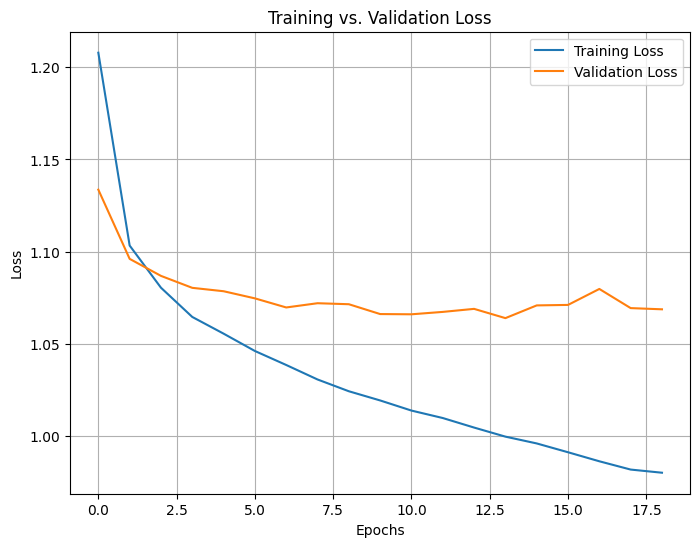

In [122]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Step 2: Create a range of epochs
epochs_range = range(len(training_loss))

# Step 3: Plot the Training vs. Validation Loss
plt.figure(figsize=(8, 6))
plt.plot(epochs_range, training_loss, label='Training Loss')
plt.plot(epochs_range, validation_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


Make Predictions on test.csv

For both models, use the test.csv data (X_test) to generate predictions for the customer segments.

Convert the softmax output to predicted class labels (A, B, C, or D).

In [124]:

X_test = test_data  # Ensure test_data has no 'Segmentation' column
X_test_prepared = preprocessor.transform(X_test)  # Apply the same transformations used on X_train

# Step 2: Make predictions using model_1
predictions_model_1 = model.predict(X_test_prepared)

# Step 3: Make predictions using best_model
predictions_best_model = best_model.predict(X_test_prepared)

# Step 4: Convert softmax outputs to predicted class labels (integer form)
predicted_classes_model_1 = np.argmax(predictions_model_1, axis=1)
predicted_classes_best_model = np.argmax(predictions_best_model, axis=1)

# Step 5: Convert integer class labels back to original class labels (A, B, C, D)
# Assuming label_encoder was used for encoding y_train
predicted_labels_model_1 = label_encoder.inverse_transform(predicted_classes_model_1)
predicted_labels_best_model = label_encoder.inverse_transform(predicted_classes_best_model)

# Step 6: Print or return the predictions
print("Predictions from model_1:", predicted_labels_model_1)
print("Predictions from best_model:", predicted_labels_best_model)


83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Predictions from model_1: ['A' 'C' 'A' ... 'A' 'B' 'D']
Predictions from best_model: ['A' 'C' 'A' ... 'A' 'B' 'D']


In [125]:
y_pred_model_1 = model.predict(X_train_transformed)
y_pred_model_2 = best_model.predict(X_train_transformed)

y_pred_labels_model_1 = np.argmax(y_pred_model_1, axis=1)
y_pred_labels_model_2 = np.argmax(y_pred_model_2, axis=1)

# Convert one-hot encoded labels to original form
y_train_labels = np.argmax(y_train_transformed, axis=1)

# Generate classification reports
report_model_1 = classification_report(y_train_labels, y_pred_labels_model_1)
report_model_2 = classification_report(y_train_labels, y_pred_labels_model_2)

print(f"Classification Report of best practices model (model_1):\n{report_model_1}")
print(f"Classification Report of keras tuner model (model_2):\n{report_model_2}")

253/253 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
253/253 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Classification Report of best practices model (model_1):
              precision    recall  f1-score   support

           0       0.49      0.53      0.51      1972
           1       0.47      0.31      0.37      1858
           2       0.57      0.61      0.59      1970
           3       0.66      0.76      0.71      2268

    accuracy                           0.56      8068
   macro avg       0.55      0.55      0.54      8068
weighted avg       0.55      0.56      0.55      8068

Classification Report of keras tuner model (model_2):
              precision    recall  f1-score   support

           0       0.49      0.53      0.51      1972
           1       0.47      0.31      0.37      1858
           2       0.57      0.61      0.59      1970
           3       0.66      0.76      0.71      2268

    accuracy                           0.56      8068
   macro avg       0.55      0.55      0.54   

In [126]:

if 'Segmentation' in test_data.columns:
    X_test = test_data.drop(columns=['Segmentation'])  # Features
    y_test = test_data['Segmentation']  # Ground truth labels

    # Step 2: Preprocess X_test using the same preprocessor used for training
    X_test_prepared = preprocessor.transform(X_test)

    # Step 3: Encode y_test using the same LabelEncoder used for y_train
    y_test_encoded = label_encoder.transform(y_test)  # Convert 'A', 'B', 'C', 'D' to integers

    # Step 4: Generate predictions for both models
    predicted_classes_model_1 = np.argmax(model_1.predict(X_test_prepared), axis=1)
    predicted_classes_best_model = np.argmax(best_model.predict(X_test_prepared), axis=1)

    # Step 5: Compute confusion matrix for model_1
    conf_matrix_model_1 = confusion_matrix(y_test_encoded, predicted_classes_model_1)

    # Step 6: Compute confusion matrix for best_model
    conf_matrix_best_model = confusion_matrix(y_test_encoded, predicted_classes_best_model)

    # Step 7: Plot heatmap for confusion matrix of model_1
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix_model_1, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title('Confusion Matrix - Model 1')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # Step 8: Plot heatmap for confusion matrix of best_model
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix_best_model, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title('Confusion Matrix - Best Model')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
else:
    print("No ground truth labels found in the test.csv file. Confusion matrix cannot be generated.")


No ground truth labels found in the test.csv file. Confusion matrix cannot be generated.


In [127]:
# Create a DataFrame with Customer_ID and Predicted_Segment for model 1
df_model_1 = pd.DataFrame({'Customer_ID': test_df['ID'], 'Predicted_Segment': predicted_classes_model_1})

# Create a DataFrame with Customer_ID and Predicted_Segment for model 2
df_model_2 = pd.DataFrame({'Customer_ID': test_df['ID'], 'Predicted_Segment': predicted_classes_best_model})

# Specify the folder path
folder_path = '/content/drive/MyDrive/Colab Notebooks/'

# Save the predictions for model 1 to a CSV file in the specified folder
df_model_1.to_csv(f'{folder_path}/model_1_predictions_final.csv', index=False)

# Save the predictions for model 2 to a CSV file in the specified folder
df_model_2.to_csv(f'{folder_path}/model_2_predictions_final.csv', index=False)

Save Predictions